## Loading the original model to try inference

In [ ]:
from tensorflow.keras.models import load_model

# Load the pre-trained model
model = load_model("final_forthesis_bidirectionallstm_and_encoders_exercise_classifier_model.h5")
weights = model.get_weights()

# Display model architecture
model.summary()

# Get the input shape from the first layer
input_shape = model.input_shape[1:] 
print("Input shape:", input_shape)
print("weights:", len(weights))



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_10                │ (None, 30, 182)        │        82,992 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 30, 182)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 182)            │       199,472 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 182)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           732 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 283,198 (1.08 MB)

 Trainable params: 283,196 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Input shape: (30, 22)
weights: 14


In [ ]:
import ExerciseAiTrainer as exercise #restart kernel if you modified the ExerciseAiTrainer.py file (otherwise it will not reload the changes)

# DEMO_VIDEO = 'data/conditioning exercise/002431597.mp4' and 072245212 # detect the squat that's good
DEMO_VIDEO = 'demo_2.mp4' 

exer = exercise.Exercise()
exer.classify_exercise_from_video(DEMO_VIDEO)

Starting video classification...


c:\Users\samyv\OneDrive\Documents\delft\1a\computer vision\project\finetuned fitness trainer messy version\ai_trainer\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
Predicted Exercise: barbell biceps curl


'barbell biceps curl'

## Processing MPII Dataset for fine-tuning

The MPII dataset provides 25 files of 20 giga each containing videos of 400 activities. For this project, we have to process all this data to keep only walking, running, and bicycling videos. The final dataset used for fine-tuning (around 3 giga) can be provided if necessary.

In [ ]:
import scipy.io
import pandas as pd
import numpy as np

# Load the .mat file
mat_data = scipy.io.loadmat(r"..\mpii_human_pose_v1_u12_2\mpii_human_pose_v1_u12_1.mat") # Downloaded from https://www.mpi-inf.mpg.de/departments/computer-vision-and-machine-learning/software-and-datasets/mpii-human-pose-dataset/download

# Print available keys in the .mat file
print(mat_data.keys())

release_data = mat_data['RELEASE']
print(type(release_data)) 

if release_data.dtype.names:
    print("Fields in RELEASE:", release_data.dtype.names)

annolist = release_data['annolist'][0][0][0]
act_data = release_data['act'][0][0]

def get_filtered_annotations(cat_name): # converting matlab files to python makes it difficult to read the data
    """ This function keeps the id of the videos that are in the category cat_name.
     Later used to keep only the videos that are in the categories we want to keep """
    return [
        annolist[i][0][0][0][0][0] for i, entry in enumerate(act_data) 
        if entry['cat_name'].size > 0 and entry['cat_name'][0] == cat_name
    ]

running_annos = get_filtered_annotations('running')

print("Number of annotations for this cat:", len(running_annos),running_annos[:10])

cat_to_keep = ['running','walking','bicycling']#,'conditioning exercise']#,'sports']
#make an annotation list for each category
annos = {cat: get_filtered_annotations(cat) for cat in cat_to_keep}
# Count the number of annotations for each category
anno_count = {cat: len(annos[cat]) for cat in cat_to_keep}
print(anno_count)

#let's keep running,walking and bicycling and we will try to fine tune the model to classify these 3 categories


Number of annotations for this cat: 316 ['089114311.jpg', '099296480.jpg', '007379656.jpg', '055385428.jpg', '096930254.jpg', '052309784.jpg', '069574869.jpg', '045454106.jpg', '012020906.jpg', '054448910.jpg']
{'running': 316, 'walking': 608, 'bicycling': 533, 'conditioning exercise': 1755}


C:\Users\samyv\AppData\Local\Temp\ipykernel_11044\971564089.py:8: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if entry['cat_name'].size > 0 and entry['cat_name'][0] == cat_name


In [ ]:
import os
import shutil

def clean_base_folder(base_folder):
    """ This function deletes all folders inside the base_folder that are not in the annos dictionary."""
    # Extract all filenames from annos and remove the ".jpg" extension
    valid_folders = {filename.split(".")[0] for cat in annos for filename in annos[cat]}

    print("Valid folders:", valid_folders)
    # Get all folders inside
    all_folders = [f for f in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, f))]
    print("All folders:", len(all_folders))
    # Filter folders that are not in valid_folders
    folders_to_delete = [f for f in all_folders if f not in valid_folders]

    counter = 0
    # Delete the unwanted folders
    for folder in folders_to_delete:
        counter += 1
        folder_path = os.path.join(base_folder, folder)
        shutil.rmtree(folder_path)
        print(f"Deleted folder: {folder_path}")

    print(f"Deleted {counter} folders.")
    print("Cleanup complete!")


# Define the base folder that you get when you extract the archive downloaded from the MPII dataset
# base_folder = "2"
# Clean the base folder
# clean_base_folder(base_folder)



Each video is in fact stored as around 40 frames, but the classification model we use requires a video as input.

In [ ]:
import cv2
import os

def make_videos(base_folder,output_base):
    # Ensure base output folder exists
    os.makedirs(output_base, exist_ok=True)

    # Convert filenames to a dict {folder_name: category}
    folder_to_category = {filename.split(".")[0]: category for category, filenames in annos.items() for filename in filenames}

    # Get all folders inside base_folder
    all_folders = [f for f in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, f))]

    c=0
    for folder in all_folders:
        c+=1
        folder_path = os.path.join(base_folder, folder)
        
        # Get the category for this folder (skip if not in annos)
        category = folder_to_category.get(folder)
        if not category:
            print(f"Skipping {folder}, not found in annos.")
            continue

        # Define category specific output folder
        category_output_folder = os.path.join(output_base, category)
        os.makedirs(category_output_folder, exist_ok=True)

        # Get all image frames in the folder
        images = sorted([img for img in os.listdir(folder_path) if img.endswith(('.png', '.jpg', '.jpeg'))])

        if not images:
            print(f"No images found in {folder}, skipping...")
            continue

        # Read the first image to get frame size
        first_frame = cv2.imread(os.path.join(folder_path, images[0]))
        height, width, _ = first_frame.shape

        # Define video writer
        video_filename = os.path.join(category_output_folder, f"{folder}.mp4")
        fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
        fps = 30  # Adjust as needed by the original model

        video = cv2.VideoWriter(video_filename, fourcc, fps, (width, height))

        # Add frames to the video
        for image in images:
            frame = cv2.imread(os.path.join(folder_path, image))
            video.write(frame)

        video.release()
        print(f"Video saved: {video_filename}")
        # if c==10:
        #     break

    print("All videos created successfully!")


# Base folder containing all subfolders with frames
base_folder = "24"

# Output base folder
output_base = "data"

# Clean folder then create videos from frames
clean_base_folder(base_folder)
make_videos(base_folder, output_base)


Valid folders: {'094574970', '062501325', '010580502', '016704191', '019854020', '032614972', '009072088', '039027886', '007411917', '017264064', '096957205', '032361022', '021546291', '063239626', '061285477', '001760252', '041628493', '004147986', '045364123', '051821832', '071902282', '075659393', '050857792', '051669839', '048640504', '049113854', '014416006', '094304881', '088058244', '037638754', '023108085', '058138490', '079804658', '098142142', '092837255', '075758383', '054690902', '054659426', '045039008', '065687330', '087450530', '019946269', '044973984', '045454106', '047190251', '027072276', '033808441', '031443411', '024685703', '080369345', '042906237', '066144084', '078274567', '087476606', '053976449', '087555665', '080978853', '069199252', '022540211', '051078162', '042748969', '060634531', '061418624', '085615362', '021618857', '078969943', '094197443', '076451656', '020265692', '001272728', '096062698', '038461108', '032694102', '019587219', '087797432', '05156418

### Messy data exploration (can be disregarded)

In [ ]:
### data exploration quite messy because of the matlab structure if makes arrays of arrays of arrays of arrays
annolist = release_data['annolist'][0][0][0]
print("name of image 0 ",annolist[0][0][0][0][0][0],len(annolist[0][0][0][0])) #just to get the id...what
print("name of image 1 ",annolist[1],len(annolist[1])) 

# print act field
act_data = release_data['act'][0][0]
print(len(release_data['act'][0][0]),len(release_data['annolist'][0][0][0]))
print("act_data",act_data,len(act_data))
# print(len(act_data))


# Extract 'act_name' values 
act_names = [entry['act_name'][0] if entry['act_name'].size > 0 else None for entry in act_data]
act_names = [entry[0] for entry in act_names if entry.size > 0]
unique_act_names = sorted(set(act_names))
print("uniqu act names",unique_act_names)

cat_names = [entry['cat_name'][0] if entry['cat_name'].size > 0 else None for entry in act_data]
cat_names = [entry[0] for entry in cat_names if entry.size > 0]
unique_cat_names = sorted(set(cat_names))
print("unique cat names",unique_cat_names)

# categories to keep : sports, running, walking,bicycling,conditioning exercise,
# activities to keep : calisthenics, 'home exercise, general',
conditioning_exercise_count = sum(1 for act in cat_names if 'conditioning exercise' in act.lower())
print(f"Count of 'conditioning exercise': {conditioning_exercise_count}")

# Create a list of act_names where the corresponding cat_name is 'conditioning exercise'
conditioning_exercise_act_names = [
    act for act, cat in zip(act_names, cat_names) if 'conditioning exercise' in cat.lower()
]

# Print the act_names for 'conditioning exercise'
unique_conditioning_exercise_act_names = list(set(conditioning_exercise_act_names))

# Print the unique act names for 'conditioning exercise'
print("Unique act_names for 'conditioning exercise':")
for act in unique_conditioning_exercise_act_names:
    print(act)



# Filter action names that contain the word 'home'
home_act_names = [act for act in unique_act_names if 'home' in act.lower()]
# Print the filtered action names
print(home_act_names)
home_exercise_count = sum(1 for act in act_names if 'home exercise, general' in act.lower())
# Print the count
print(f"Count of 'home exercise, general': {home_exercise_count}")

name of image 0  037454012.jpg 1
name of image 1  (array([[(array(['095071431.jpg'], dtype='<U13'),)]], dtype=[('name', 'O')]), array([[(array([[8.07816613]]), array([[(array([[881]], dtype=uint16), array([[394]], dtype=uint16))]],
              dtype=[('x', 'O'), ('y', 'O')]))                                                         ,
        (array([[8.90412938]]), array([[(array([[338]], dtype=uint16), array([[210]], dtype=uint8))]],
              dtype=[('x', 'O'), ('y', 'O')]))                                                        ]],
      dtype=[('scale', 'O'), ('objpos', 'O')]), array([], shape=(1, 0), dtype=float64), array([], shape=(1, 0), dtype=float64)) 4
24987 24987
act_data [[(array([], dtype='<U1'), array([], dtype='<U1'), array([[-1]], dtype=int16))]
 [(array([], dtype='<U1'), array([], dtype='<U1'), array([[-1]], dtype=int16))]
 [(array([], dtype='<U1'), array([], dtype='<U1'), array([[-1]], dtype=int16))]
 ...
 [(array(['transportation'], dtype='<U14'), array(['pushin

### Computing X and y for the new dataset

In order to fine-tune the model, we need to extract from the training videos the features used by the original model.

In [ ]:
import ExerciseAiTrainer as exercise
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="google.protobuf.symbol_database")


classes = ["running", "walking", "bicycling"]  # 3 new sports

label_encoder_path = "label_encoder.pkl"

exer = exercise.Exercise()
exer.make_training_data(classes,label_encoder_path) # make_training_data was added to the original ExerciseAiTrainer.py file, it computes the features used for activity classification and creates X and y


Loading processed videos file...
Processing running videos...
Found 316 videos for running
Already processed video: data\running\000575866.mp4
Already processed video: data\running\000637904.mp4
Already processed video: data\running\000924231.mp4
Already processed video: data\running\001162660.mp4
Already processed video: data\running\001200303.mp4
Already processed video: data\running\001852458.mp4
Already processed video: data\running\001940125.mp4
Already processed video: data\running\002162699.mp4
Already processed video: data\running\002534860.mp4
Already processed video: data\running\002574241.mp4
Already processed video: data\running\003474215.mp4
Already processed video: data\running\003925305.mp4
Already processed video: data\running\003926941.mp4
Already processed video: data\running\005574085.mp4
Already processed video: data\running\006331925.mp4
Already processed video: data\running\007173534.mp4
Already processed video: data\running\007379656.mp4
Already processed video: 

In [ ]:
import pickle
import numpy as np
classes = ["running", "walking", "bicycling"]#,"conditioning exercise"]  # 3 new sports

def load_progressive_pickle(X_save_path, y_save_path):
    """Load data progressively from pickle files and reconstruct the original shape."""
    
    X = []
    y = []
    
    # Load features from X pickle file
    with open(X_save_path, "rb") as f:
        while True:
            try:
                new_X = pickle.load(f)
                # Remove the extra dimension if it is present ((1, 30, 22) -> (30, 22))
                if new_X.ndim == 3:
                    new_X = np.squeeze(new_X, axis=0) 
                X.append(new_X) 
            except EOFError:
                break  # End of file reached

    # Load labels from y pickle file
    with open(y_save_path, "rb") as f:
        while True:
            try:
                new_y = pickle.load(f)
                y.append(new_y.item()) 
            except EOFError:
                break  # End of file reached
    
    # Convert lists to numpy arrays to reconstruct the original shape
    X = np.array(X)  # Shape: (num_samples, 30, 22)
    y = np.array(y)  # Shape: (num_samples,)

    return X, y

X = []
y = []

# Loop through classes and load data for each
for c in classes:
    # Load data for the class
    X_c, y_c = load_progressive_pickle(f"data/{c}/X.pkl", f"data/{c}/y.pkl")
    print(f"X shape for {c}: {len(X_c)} sequences")

    # Append class data to X and y
    X.extend(X_c)
    y.extend(y_c)

# Convert X and y to NumPy arrays
X = np.array(X)
y = np.array(y)

print(f"Final X shape: {X.shape}")
print(f"Final y shape: {y.shape}")
#print y unique values
print(np.unique(y))
print(y[y==0].shape,y[y==1].shape,y[y==2].shape) # the order has changed compared to the classes list ! 0: bicycling, 1: running, 2: walking 


X shape for running: 306 sequences
X shape for walking: 613 sequences
X shape for bicycling: 459 sequences
Final X shape: (1378, 30, 22)
Final y shape: (1378,)
[0 1 2]
(459,) (306,) (613,)


In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
import numpy as np

print("X shape",X.shape)
print("y shape",y.shape)
from sklearn.model_selection import train_test_split

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
# Convert to NumPy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
# Normalize X_train
num_samples, seq_length, num_features = X_train.shape
X_train = X_train.reshape(num_samples * seq_length, num_features)  # Flatten
X_train = scaler.fit_transform(X_train)  # Fit and transform
X_train = X_train.reshape(num_samples, seq_length, num_features)  # Reshape back

# Apply same transformation to X_test
num_samples, seq_length, num_features = X_test.shape
X_test = X_test.reshape(num_samples * seq_length, num_features)  # Flatten
X_test = scaler.transform(X_test)  # Only transform (DO NOT FIT AGAIN)
X_test = X_test.reshape(num_samples, seq_length, num_features)  # Reshape back
# One-hot encode y_train and y_test
y_train = to_categorical(y_train, num_classes=len(classes))
y_test = to_categorical(y_test, num_classes=len(classes))

# Save for reuse
# np.save("X_train.npy", X_train)
# np.save("y_train.npy", y_train)
# np.save("X_test.npy", X_test)
# np.save("y_test.npy", y_test)


X shape (1378, 30, 22)
y shape (1378,)


In [ ]:

import numpy as np
# load the data
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
# print(y_train[:5])  # Check first 5 labels
y_train_count = np.argmax(y_train, axis=1)  # Convert from one-hot to class labels
unique, counts = np.unique(y_train_count, return_counts=True)
print(dict(zip(unique, counts)))  # Check class distribution



## Transfer Learning 

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


X_train = np.load("training/X_train.npy")
y_train = np.load("training/y_train.npy")
X_test = np.load("training/X_test.npy")
y_test = np.load("training/y_test.npy")

classes = ["bicycling", "running", "walking"]
def plot_test_results(model): # plot test results for the new model
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Test shapes : {y_test.shape} {X_test.shape}")
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    y_pred = model.predict(X_test)
    y_pred_classes = y_pred.argmax(axis=1)  # Convert probabilities to class indices
    y_true_classes = y_test.argmax(axis=1)  # Convert one-hot labels to class indices

    print(classification_report(y_true_classes, y_pred_classes))

    # Plot confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes,)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


### Fine-tune one model

Once you found a satisfying set of parameters with random search, you can test the model here.

In [ ]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.utils.class_weight import compute_class_weight
import tensorflow

# Get the output of the last LSTM layer
x = model.layers[-2].output  

# add a new Dense layer before the classification layer
new_output = Dense(64, activation='relu', name="dense_hidden")(x)  
new_output = Dropout(0.5)(new_output)
# Add the new output layer with 3 classes : bicycling, running, walking
new_output = Dense(3, activation='softmax', name="dense_new")(new_output)

# Create a new model
new_model = Model(inputs=model.inputs, outputs=new_output)

# Freeze all layers except the last ones (that's a parameter to tune)
for layer in new_model.layers[:-3]:  
    layer.trainable = False

# new_model.summary()

class_weights = compute_class_weight('balanced', classes=np.unique(y_train.argmax(axis=1)), y=y_train.argmax(axis=1)) #because the classes are imbalanced, not used in the final model
class_weights = dict(enumerate(class_weights))
# print(class_weights)

new_model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy']) #use a smaller learning rate to preserve learned features
# if learning_rate is too high then the model learn better for walking and bicycling (majority classes) but not for running
# if learning_rate is a bit lower then the model learn more consistently for all classes

new_model.fit(X_train, y_train, epochs=100, batch_size=4, validation_split=0.3,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_accuracy',patience=4)], verbose=1)#, class_weight=class_weights) #seems to be worse with class weights

# y_train_count = np.argmax(y_train, axis=1)  # Convert from one-hot to class labels
# unique, counts = np.unique(y_train_count, return_counts=True)
# print(dict(zip(unique, counts)))  # Check class distribution
# y_test_count = np.argmax(y_test, axis=1)  # Convert from one-hot to class labels
# unique, counts = np.unique(y_test_count, return_counts=True)
# print(dict(zip(unique, counts)))  # Check class distribution

#save model as h5
# new_model.save("finetuned_bidirectional_model.h5")

Epoch 1/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5929 - loss: 0.9037 - val_accuracy: 0.6677 - val_loss: 0.7673
Epoch 2/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6905 - loss: 0.6785 - val_accuracy: 0.6737 - val_loss: 0.7584
Epoch 3/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7301 - loss: 0.6442 - val_accuracy: 0.6707 - val_loss: 0.7651
Epoch 4/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7237 - loss: 0.6447 - val_accuracy: 0.6616 - val_loss: 0.7657
Epoch 5/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7347 - loss: 0.6307 - val_accuracy: 0.6677 - val_loss: 0.7729
Epoch 6/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7192 - loss: 0.6254 - val_accuracy: 0.6677 - val_loss: 0.7802


{0: 367, 1: 245, 2: 490}
{0: 92, 1: 61, 2: 123}


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7468 - loss: 0.6926
Test shapes : (276, 3) (276, 30, 22)
Test Loss: 0.7172
Test Accuracy: 0.7101
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
              precision    recall  f1-score   support

           0       0.81      0.71      0.76        92
           1       0.66      0.61      0.63        61
           2       0.67      0.76      0.71       123

    accuracy                           0.71       276
   macro avg       0.71      0.69      0.70       276
weighted avg       0.72      0.71      0.71       276



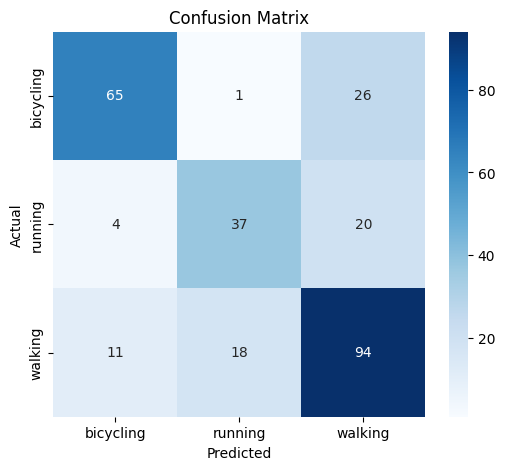

In [ ]:
plot_test_results(new_model)

### Random search

Testing various combinations of hyperparameters and architectures.

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42) # using 30% of the training data for validation

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

# Define model builder function for KerasTuner
def build_model(hp):
    # Extract last LSTM layer before Dense
    x = model.layers[-2].output  
    
    # The extra dense layer with tunable number of units does not seem to improve the test accuracy
    units = hp.Int('units', min_value=16, max_value=128, step=16)
    new_output = Dense(units, activation='relu', name="dense_hidden")(x)  
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    new_output = Dropout(dropout_rate)(new_output) 

    new_output = Dense(3, activation='softmax', name="dense_new")(new_output)

    # Create new model
    new_model = Model(inputs=model.inputs, outputs=new_output)

    # Tune number of trainable layers
    trainable_layers = hp.Int('trainable_layers', min_value=1, max_value=len(model.layers), step=1)
    for layer in new_model.layers[:-trainable_layers]:  
        layer.trainable = False  # Freeze early layers

    # Tune learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3])

    # Tune batch size
    batch_size = hp.Choice('batch_size', values=[2, 4, 8, 16, 32])

    # Compile model
    new_model.compile(
        optimizer=Adam(learning_rate=learning_rate), 
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )

    return new_model

# Set up Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=400,  # Number of different hyperparameter configurations to try
    executions_per_trial=2,  # Number of times each model is trained per config
    directory='tuner_results',
    project_name='transfer_learning_tuning_hiddenLayerDropout'
)

tuner.search_space_summary()

# Run hyperparameter tuning
tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  #put a high number of epochs as we use EarlyStopping
    callbacks=[tf.keras.callbacks.EarlyStopping('val_accuracy', patience=3)],
    batch_size=16,  # this should be overridden by the tuner-selected batch size
)

#Retrieve the best model and parameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

print(f"\n Best Hyperparameters: {best_hps.values}")

best_epochs = best_hps.get('epochs') if 'epochs' in best_hps.values else 50
best_batch_size = best_hps.get('batch_size')
print(f"Training with {best_epochs} epochs and batch size {best_batch_size}")

plot_test_results(best_model)


Trial 319 Complete [00h 05m 48s]
val_accuracy: 0.8247734308242798

Best val_accuracy So Far: 0.8368580043315887
Total elapsed time: 07h 51m 01s

Search: Running Trial #320

Value             |Best Value So Far |Hyperparameter
16                |64                |units
0.4               |0.5               |dropout_rate
1                 |3                 |trainable_layers
0.005             |0.001             |learning_rate
16                |2                 |batch_size



Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x000001DEFA32A480>
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\weakref.py", line 370, in remove
    self = selfref()
           ^^^^^^^^^
KeyboardInterrupt: 
